# Manuscript6 - Region-to-region information transfer mapping

## Analysis for Fig. 6


## Master code for Ito et al., 2017¶
#### Takuya Ito (takuya.ito@rutgers.edu)


#### Note: Actual computation of region-to-region activity flow mapping predictions were computed on supercomputer cluster


In [44]:
import sys
sys.path.append('utils/')
import numpy as np
import loadGlasser as lg
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.sandbox.stats.multicomp as mc
import multiprocessing as mp
import multregressionconnectivity as mreg
%matplotlib inline
import nibabel as nib
import os
import permutationTesting as pt
os.environ['OMP_NUM_THREADS'] = str(1)

from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm


class MidpointNormalize(Normalize):
    """ Class to create the midpoint for color schemes in matplotlib """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
class MidpointNormalize2(Normalize):
    """ 
    Class to create the midpoint for color schemes in matplotlib 
    This allows very low values to be visible in a monotonic color scheme
    """

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        t1 = (self.midpoint - self.vmin)/2.0
        t2 = (self.vmax - self.midpoint)/30.0 + self.midpoint
        x, y = [self.vmin, t1, self.midpoint, t2, self.vmax], [0, 0.25, .5, .75, 1.0]
        return np.ma.masked_array(np.interp(value, x, y))

Define functions to create color bars discrete; found on stackoverflow

In [45]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def colorbar_index(ncolors, cmap,norm=None):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap,norm=norm)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in xrange(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)


# 0.0 Basic parameters

In [46]:
# Set basic parameters
basedir = '/projects2/ModalityControl2/'
datadir = basedir + 'data/'
resultsdir = datadir + 'resultsMaster/'
runLength = 4648

subjNums = ['032', '033', '037', '038', '039', '045', 
            '013', '014', '016', '017', '018', '021', 
            '023', '024', '025', '026', '027', '031', 
            '035', '046', '042', '028', '048', '053', 
            '040', '049', '057', '062', '050', '030', '047', '034']

glasserparcels = lg.loadGlasserParcels()
networkdef = lg.loadGlasserNetworks()

# Define the main networks (in main manuscript)
networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud':8, 'aud2':9, 'dan':11}
# Force aud2 key to be the same as aud1
# aud2_ind = np.where(networkdef==networkmappings['aud2'])[0]
# networkdef[aud2_ind] = networkmappings['aud1']
# Merge aud1 and aud2
# networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud':8, 'dan':11}

nParcels = 360

# Import network reordering
networkdir = '/projects/AnalysisTools/netpartitions/ColeLabNetPartition_v1/'
# networkorder = np.loadtxt(networkdir+'community_order.txt',delimiter=',',dtype=int) - 1 #Subtract 1 for python indices
# Original reordering relies on this archaic ordering from L->R
# origorder = np.loadtxt(basedir + 'data/GlasserKKPartition/Glasser_KK_Partitions_old.csv')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
order = networkorder
order.shape = (len(networkorder),1)



# Construct xticklabels and xticks for plotting figures
networks = networkmappings.keys()
xticks = {}
reorderednetworkaffil = networkdef[order]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net
    
# Load in Glasser parcels in their native format (vertex formula)
glasser2 = nib.load('/projects/AnalysisTools/ParcelsGlasser2016/archive/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii')
glasser2 = np.squeeze(glasser2.get_data())

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# 1.0 Run region-to-region information transfer mapping

##### Due to computational constraints, all region-to-region activity flow mapping procedures and the RSA analyses were run on the supercomputer using  MATLAB scripts in ./SupercomputerScripts/Fig6_RegionToRegionInformationTransferMapping/


# 2.0 Compute group statistics for information transfer estimates (ITE)
#### Perform for all 3 rule domains, across subjects for every pair of region-to-region transfers

In [47]:
## Load in NM3 Data
ruledims = ['logic','sensory','motor']
datadir = '/projects2/ModalityControl2/data/resultsMaster/Manuscript6andS2and7_RegionToRegionITE/'
# Load in RSA matrices
iteMats = {}
corrMats = {}
errMats = {}
df_stats = {}
for ruledim in ruledims:
    iteMats[ruledim] = np.zeros((nParcels,nParcels,len(subjNums)))
    corrMats[ruledim] = np.zeros((nParcels,nParcels,len(subjNums)))
    errMats[ruledim] = np.zeros((nParcels,nParcels,len(subjNums)))
    
    df_stats[ruledim] = {}
    scount = 0
    for subj in subjNums:
        filename = datadir +subj+'_' + ruledim + '_RegionToRegionActFlowGlasserParcels.csv'
        iteMats[ruledim][:,:,scount] = np.loadtxt(filename, delimiter=',')

        scount += 1



In [48]:
## Compute Group Stats
for ruledim in ruledims:
    ## Compute group statistics
    # Compute average across subjects
    df_stats[ruledim]['avgrho'] = np.mean(iteMats[ruledim],axis=2)
    # Compute t-test for each pairwise connection
    t = np.zeros((nParcels,nParcels))
    p = np.zeros((nParcels,nParcels))
    for i in range(nParcels):
        for j in range(nParcels):
            t[i,j], p[i,j] = stats.ttest_1samp(iteMats[ruledim][i,j,:], 0)
            # One-sided t-test so...
            if t[i,j] > 0:
                p[i,j] = p[i,j]/2.0
            else:
                p[i,j] = 1.0-(p[i,j]/2.0)
    
    df_stats[ruledim]['t'] = t
    df_stats[ruledim]['p'] = p
    
    ## Run multiple corrections
    triu_ind = np.triu_indices(nParcels,k=1)
    tril_ind = np.tril_indices(nParcels,k=-1)
    tmpq = []
    tmpq.extend(df_stats[ruledim]['p'][triu_ind])
    tmpq.extend(df_stats[ruledim]['p'][tril_ind])
    # only run FDR correction on non-NaN values
    ind_nans = np.isnan(tmpq)
    ind_nonnan = np.where(ind_nans==False)[0]
    tmpq = np.asarray(tmpq)
    tmpq2 = mc.fdrcorrection0(tmpq[ind_nonnan])[1]
    tmpq[ind_nonnan] = tmpq2
    qmat = np.zeros((nParcels,nParcels))
    qmat[triu_ind] = tmpq[0:len(triu_ind[0])]
    qmat[tril_ind] = tmpq[len(tril_ind[0]):]
    
    df_stats[ruledim]['q'] = qmat
    np.fill_diagonal(df_stats[ruledim]['q'],1)
    


## 2.1 Visualize information transfer matrices (Threshold and Unthresholded)

/home/usr/local/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: RuntimeWarning: invalid value encountered in less


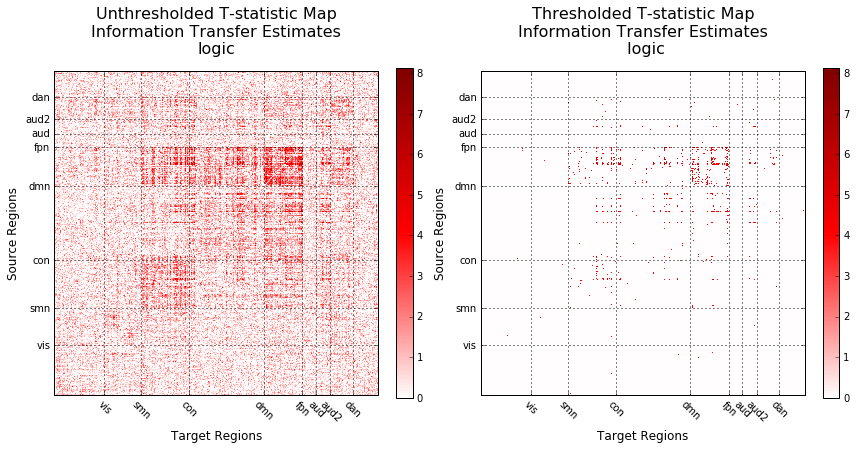

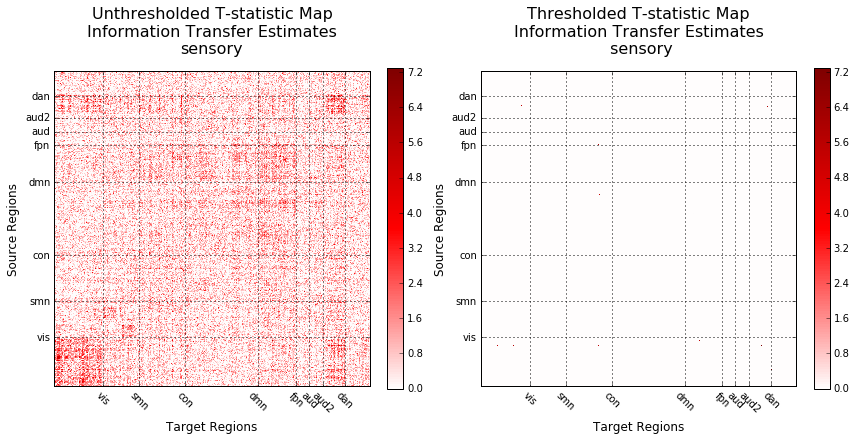

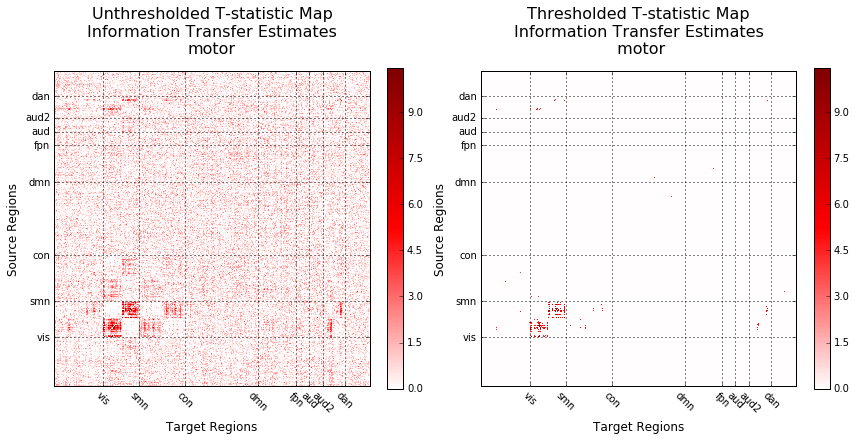

In [49]:
# Visualize Unthresholded and thresholded side-by-side
order = networkorder
order.shape = (len(networkorder),1)
for ruledim in ruledims:

    # Unthresholded t-stat map
    plt.figure(figsize=(12,10))
    plt.subplot(121)
    # First visualize unthresholded
    mat = df_stats[ruledim]['t'][order,order.T]
    ind = np.isnan(mat)
    mat[ind] = 0
    pos = mat > 0
    mat = np.multiply(pos,mat)
    norm = MidpointNormalize(midpoint=0)
    plt.imshow(mat,origin='lower',vmin=0, norm=norm, interpolation='none',cmap='seismic')
    plt.colorbar(fraction=0.046)
    plt.title('Unthresholded T-statistic Map\nInformation Transfer Estimates\n' + ruledim,
              fontsize=16,y=1.04)
    plt.xlabel('Target Regions',fontsize=12)
    plt.ylabel('Source Regions', fontsize=12)
    plt.xticks(xticks.keys(),xticks.values(), rotation=-45)
    plt.yticks(xticks.keys(),xticks.values())
    plt.grid(linewidth=1)

    
    # Thresholded T-stat map
    plt.subplot(122)
    # First visualize unthresholded
    mat = df_stats[ruledim]['t']
    thresh = df_stats[ruledim]['q'] < 0.05
    mat = np.multiply(mat,thresh)
    mat = mat[order,order.T]
    ind = np.isnan(mat)
    mat[ind]=0
    pos = mat > 0
    mat = np.multiply(pos,mat)
    norm = MidpointNormalize(midpoint=0)
    plt.imshow(mat,origin='lower',norm=norm,vmin = 0,interpolation='none',cmap='seismic')
    plt.colorbar(fraction=0.046)
    plt.title('Thresholded T-statistic Map\nInformation Transfer Estimates\n ' + ruledim,
              fontsize=16, y=1.04)
    plt.xlabel('Target Regions',fontsize=12)
    plt.ylabel('Source Regions', fontsize=12)
    plt.xticks(xticks.keys(),xticks.values(), rotation=-45)
    plt.yticks(xticks.keys(),xticks.values())
    plt.grid(linewidth=1)
    plt.tight_layout()

#     plt.savefig('Fig6_RegionITE_TstatMap' + ruledim + '_FDR.pdf')

## 2.2 Compute percent of information transfers for the 7 main networks

{0: 'vis', 1: 'smn', 2: 'con', 3: 'dmn', 4: 'fpn', 5: 'aud', 6: 'dan'}


/home/usr/local/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in less


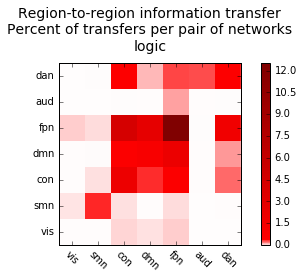

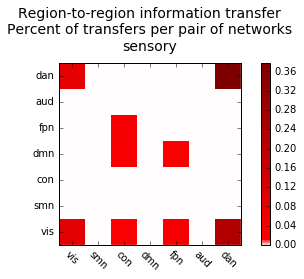

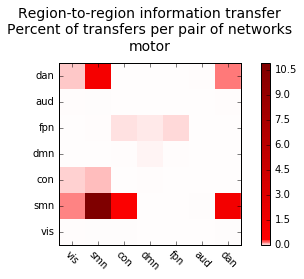

In [50]:
networks = networkmappings.keys()
netkeys = {0:'fpn', 1:'dan', 2:'con', 3:'dmn', 4:'vis', 5:'aud', 6:'smn'}
# Remake order to fit that of the glasser community ordering (region-to-region matrix ordering)
netkeys = {0:'vis',1:'smn',2:'con',3:'dmn',4:'fpn', 5:'aud', 6:'dan'}

print netkeys
num_networks=len(netkeys)

netrsa_percent = {}
df_netrsa = {}

for ruledim in ruledims:
    netrsa_percent[ruledim] = np.zeros((num_networks,num_networks))
    for net1 in netkeys:
        for net2 in netkeys:
            net1_ind = np.where(networkdef==networkmappings[netkeys[net1]])[0]
            net1_ind.shape = (len(net1_ind),1)
            net2_ind = np.where(networkdef==networkmappings[netkeys[net2]])[0]
            net2_ind.shape = (len(net2_ind),1)
            
            thresh = df_stats[ruledim]['q'] < 0.05
            
            netrsa_percent[ruledim][net1,net2] = np.mean(thresh[net1_ind,net2_ind.T])

    plt.figure()
    norm = MidpointNormalize2(midpoint=0)
    mintmp = np.max(netrsa_percent[ruledim]*100.0)*-1.0
    maxtmp = np.max(netrsa_percent[ruledim]*100.0)
    plt.imshow(netrsa_percent[ruledim]*100.0,
               norm=norm, origin='lower', interpolation='none', cmap='seismic')
    plt.xticks(range(len(netkeys)),netkeys.values(), rotation=-45)
    plt.yticks(range(len(netkeys)),netkeys.values())
    plt.title('Region-to-region information transfer\nPercent of transfers per pair of networks\n' + ruledim, 
              fontsize=14, y = 1.04)
    cbar = plt.colorbar()
    plt.tight_layout()
#     plt.savefig('Fig6_ITE_NetworkPercent_7Nets_' + ruledim + '.pdf')

## 2.2.1 Compute the number of rule domains each network is involved in

In [51]:
numDomains_netInvolvedMat = np.zeros((netrsa_percent['logic'].shape))
numDomains_netInvolvedBar = np.zeros((num_networks,))
for ruledim in ruledims:
    tmp = netrsa_percent[ruledim] > 0
    numDomains_netInvolvedMat = numDomains_netInvolvedMat + tmp
    
    tmp2 = np.sum(netrsa_percent[ruledim] > 0,axis=1) > 0
    numDomains_netInvolvedBar = numDomains_netInvolvedBar + tmp2

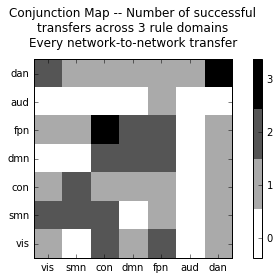

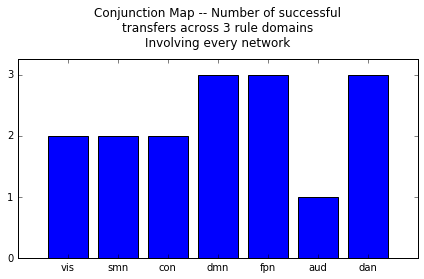

In [52]:
norm = MidpointNormalize(midpoint=0)
plt.figure()
plt.title('Conjunction Map -- Number of successful\ntransfers across 3 rule domains\nEvery network-to-network transfer',
          y=1.04)
cmap = plt.get_cmap('binary')
plt.imshow(numDomains_netInvolvedMat,origin='lower',interpolation='nearest',cmap=cmap)
colorbar_index(ncolors=4,cmap=cmap)
# mappable = plt.cm.ScalarMappable(cmap=cm)
# cbar = plt.colorbar(mappable)
# cbar.set_ticks([0,1,2,3])
plt.xticks(range(len(netkeys)),netkeys.values())
plt.yticks(range(len(netkeys)),netkeys.values())
plt.tight_layout()
# plt.savefig('Fig6_FDR_ConjunctionMatrix_ITE_7NETS.pdf')

plt.figure()
plt.title('Conjunction Map -- Number of successful\ntransfers across 3 rule domains\nInvolving every network',
          y=1.04)
plt.bar(range(num_networks),numDomains_netInvolvedBar,align='center')
plt.xticks(range(num_networks),netkeys.values())
plt.yticks(range(4),[0,1,2,3])
plt.ylim([0,3.25])
plt.tight_layout()
# plt.savefig('Fig6_ConjunctionBarPlot_ITE_7NETS.pdf')



## 2.3 Now generate figures for all 14 networks

{0: 'vis', 1: 'smn', 2: 'con', 3: 'fpn_prem', 4: 'prem', 5: 'dmn', 6: 'fpn', 7: 'aud', 8: 'aud2', 9: 'pcc', 10: 'dan', 11: 'none', 12: 'hipp', 13: 'pmulti'}


/home/usr/local/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:25: RuntimeWarning: invalid value encountered in less


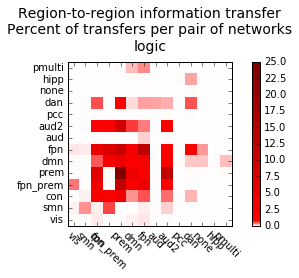

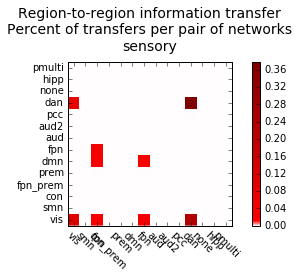

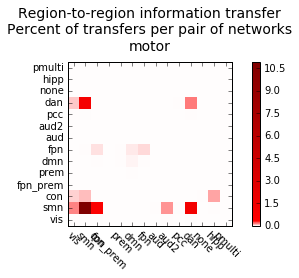

In [53]:
# # Define full set of 14 networks (used in supplementary materials)
networkmappings_full = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud':8, 'aud2':9, 'dan':11,'fpn_prem':4,
                   'prem':5, 'pcc':10, 'none':12, 'hipp':13, 'pmulti':14}
networkdef_full = lg.loadGlasserNetworks()
networks = networkmappings_full.keys()
netkeys = {0:'fpn', 1:'dan', 2:'con', 3:'dmn', 4:'vis', 5:'aud', 6:'smn'}
# Remake order to fit that of the glasser community ordering (region-to-region matrix ordering)
netkeys = {0:'vis',1:'smn',2:'con',3:'fpn_prem', 4:'prem', 5:'dmn', 6:'fpn', 7:'aud', 8:'aud2',
          9:'pcc', 10:'dan', 11:'none', 12:'hipp', 13:'pmulti'}
print netkeys
num_networks=len(netkeys)

netrsa_percent = {}
df_netrsa = {}

for ruledim in ruledims:
    netrsa_percent[ruledim] = np.zeros((num_networks,num_networks))
    for net1 in netkeys:
        for net2 in netkeys:
            net1_ind = np.where(networkdef_full==networkmappings_full[netkeys[net1]])[0]
            net1_ind.shape = (len(net1_ind),1)
            net2_ind = np.where(networkdef_full==networkmappings_full[netkeys[net2]])[0]
            net2_ind.shape = (len(net2_ind),1)
            
            thresh = df_stats[ruledim]['q'] < 0.05
            
            netrsa_percent[ruledim][net1,net2] = np.mean(thresh[net1_ind,net2_ind.T])


    plt.figure()
    norm = MidpointNormalize2(midpoint=0)
    mintmp = np.max(netrsa_percent[ruledim]*100.0)*-1.0
    maxtmp = np.max(netrsa_percent[ruledim]*100.0)
    plt.imshow(netrsa_percent[ruledim]*100.0,
               norm=norm, origin='lower', interpolation='none', cmap='seismic')
    plt.xticks(range(len(netkeys)),netkeys.values(), rotation=-45)
    plt.yticks(range(len(netkeys)),netkeys.values())
    plt.title('Region-to-region information transfer\nPercent of transfers per pair of networks\n' + ruledim,
              fontsize=14, y=1.04)
    cbar = plt.colorbar()
    plt.tight_layout()
#     plt.savefig('SFig_ITE_NetworkPercent_AllNets_' + ruledim + '_FDR.pdf')

## 2.3.1 Compute the number of rule domains each network is involved in

In [54]:
numDomains_netInvolvedMat = np.zeros((netrsa_percent['logic'].shape))
numDomains_netInvolvedBar = np.zeros((num_networks,))
for ruledim in ruledims:
    tmp = netrsa_percent[ruledim] > 0
    numDomains_netInvolvedMat = numDomains_netInvolvedMat + tmp
    
    tmp2 = np.sum(netrsa_percent[ruledim] > 0,axis=1) > 0
    numDomains_netInvolvedBar = numDomains_netInvolvedBar + tmp2

#### For every network-to-network configuration

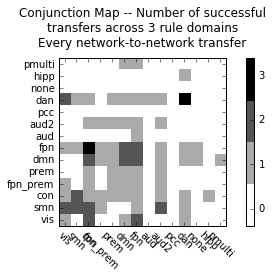

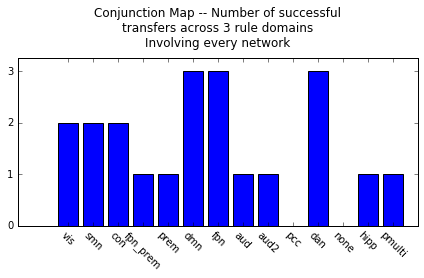

In [55]:
norm = MidpointNormalize(midpoint=0)
plt.figure()
plt.title('Conjunction Map -- Number of successful\ntransfers across 3 rule domains\nEvery network-to-network transfer', 
          y=1.04)
cmap = plt.get_cmap('binary')
plt.imshow(numDomains_netInvolvedMat,origin='lower',interpolation='nearest',cmap=cmap)
colorbar_index(ncolors=4,cmap=cmap)
plt.xticks(range(len(netkeys)),netkeys.values(), rotation=-45)
plt.yticks(range(len(netkeys)),netkeys.values())
plt.tight_layout()
# plt.savefig('SFig_ConjunctionMatrix_IT_ALLNETS_FDR.pdf')

plt.figure()
plt.title('Conjunction Map -- Number of successful\ntransfers across 3 rule domains\nInvolving every network',
          y=1.04)
plt.bar(range(num_networks),numDomains_netInvolvedBar,align='center')
plt.xticks(range(num_networks),netkeys.values(), rotation=-45)
plt.yticks(range(4),[0,1,2,3])
plt.ylim([0,3.25])
plt.tight_layout()
# plt.savefig('SFig_ConjunctionBarPlot_ITE_ALLNETS_FDR.pdf')



# 3.0 Correct for Multiple Comparisons using FWE correction (Permutation Testing)

In [56]:
pt = reload(pt)

fwe_Ts = np.zeros((nParcels,nParcels,len(ruledims)))
fwe_Ps = np.ones((nParcels,nParcels,len(ruledims)))

# Obtain indices for multiple comparisons
indices = np.ones((nParcels,nParcels))
np.fill_diagonal(indices,0)
notnan_ind = np.isnan(iteMats['logic'][:,:,0])==False
indices = np.multiply(indices,notnan_ind)
flatten_ind = np.where(indices==1)
rulecount = 0



for ruledim in ruledims:
#     tmpcor = np.arctanh(corrMats[ruledim][flatten_ind[0],flatten_ind[1],:])
#     tmperr = np.arctanh(errMats[ruledim][flatten_ind[0],flatten_ind[1],:])
    t, p = pt.permutationFWE(iteMats[ruledim][flatten_ind[0],flatten_ind[1],:], 
                             nullmean=0, permutations=1000, nproc=15)
    fwe_Ts[flatten_ind[0],flatten_ind[1],rulecount] = t
    fwe_Ps[flatten_ind[0],flatten_ind[1],rulecount] = 1.0 - p
    
    rulecount += 1

## 3.1 Visualize information transfer mapping matrices (Threshold and Unthresholded)

logic results
Average significant ITE effect = 0.0174840695268
Average significant T-stat = 6.25753028404
Maximum significant Pfwe = 0.046


Average non-significant ITE effect = 0.000844638819093
Average non-significant T-stat = 0.365094274523
Minimum non-significant Pfwe = 0.054



sensory results
Average significant ITE effect = 0.0114917551295
Average significant T-stat = 6.15198458061
Maximum significant Pfwe = 0.045


Average non-significant ITE effect = 0.000621185090309
Average non-significant T-stat = 0.269804054175
Minimum non-significant Pfwe = 0.083



motor results
Average significant ITE effect = 0.0910608141085
Average significant T-stat = 7.38019687181
Maximum significant Pfwe = 0.05


Average non-significant ITE effect = 0.000237422036756
Average non-significant T-stat = 0.103124693334
Minimum non-significant Pfwe = 0.065





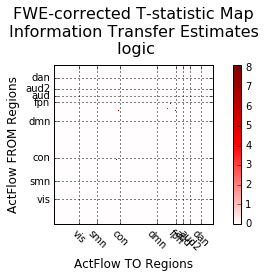

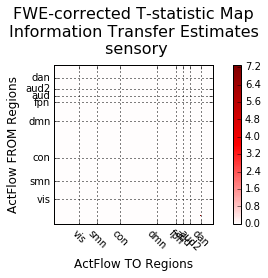

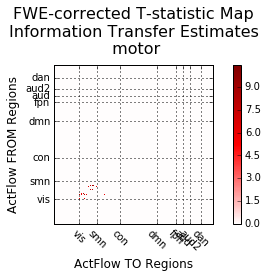

In [57]:
pthresh = .05

# Visualize FWER-corrected T-statistic map
order = networkorder
order.shape = (len(networkorder),1)
rulecount = 0
for ruledim in ruledims:
    
    # Thresholded T-stat map
    plt.figure()
    # First visualize unthresholded
    mat = fwe_Ts[:,:,rulecount].copy()
    thresh = fwe_Ps[:,:,rulecount] < pthresh
    mat = np.multiply(mat,thresh)
    mat = mat[order,order.T]
    ind = np.isnan(mat)
    mat[ind]=0
    pos = mat > 0
    mat = np.multiply(pos,mat)
    norm = MidpointNormalize(midpoint=0)
    plt.imshow(mat,origin='lower',norm=norm,vmin = 0,interpolation='none',cmap='seismic')
    plt.colorbar(fraction=0.046)
    plt.title('FWE-corrected T-statistic Map\nInformation Transfer Estimates\n ' + ruledim,
              fontsize=16, y=1.04)
    plt.xlabel('ActFlow TO Regions',fontsize=12)
    plt.ylabel('ActFlow FROM Regions', fontsize=12)
    plt.xticks(xticks.keys(),xticks.values(), rotation=-45)
    plt.yticks(xticks.keys(),xticks.values())
    plt.grid(linewidth=1)
    plt.tight_layout()

#     plt.savefig('Fig6_RegionITE_TstatMap' + ruledim + '_FWER.pdf')

    
    # Print out statistics for manuscript
    sig_ind = thresh
    nonsig_ind = sig_ind==False
    np.fill_diagonal(nonsig_ind,False) # Make sure diagonal is not included
    
    print ruledim, 'results'
    print 'Average significant ITE effect =', np.nanmean(iteMats[ruledim][sig_ind])
    print 'Average significant T-stat =', np.mean(fwe_Ts[:,:,rulecount][sig_ind])
    print 'Maximum significant Pfwe =', np.max(fwe_Ps[:,:,rulecount][sig_ind])
    print '\n'
    print 'Average non-significant ITE effect =', np.nanmean(iteMats[ruledim][nonsig_ind])
    print 'Average non-significant T-stat =', np.nanmean(fwe_Ts[:,:,rulecount][nonsig_ind])
    print 'Minimum non-significant Pfwe =', np.min(fwe_Ps[:,:,rulecount][nonsig_ind])
    print '\n\n'

    rulecount += 1


## 3.2 Compute percent of information transfers for the 7 main networks

{0: 'vis', 1: 'smn', 2: 'con', 3: 'dmn', 4: 'fpn', 5: 'aud', 6: 'dan'}


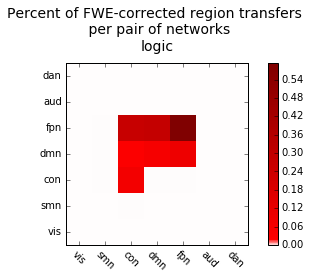

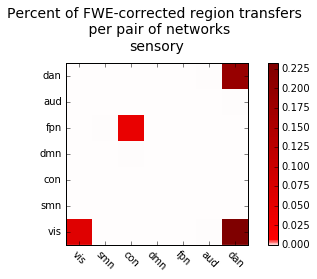

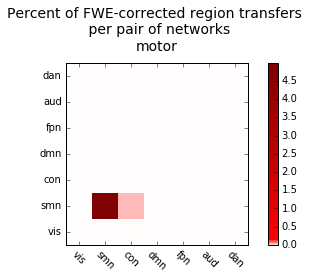

In [58]:
networks = networkmappings.keys()
netkeys = {0:'fpn', 1:'dan', 2:'con', 3:'dmn', 4:'vis', 5:'aud', 6:'smn'}
# Remake order to fit that of the glasser community ordering (region-to-region matrix ordering)
netkeys = {0:'vis',1:'smn',2:'con',3:'dmn',4:'fpn', 5:'aud', 6:'dan'}

print netkeys
num_networks=len(netkeys)

netrsa_percent = {}
df_netrsa = {}

rulecount = 0
for ruledim in ruledims:
    netrsa_percent[ruledim] = np.zeros((num_networks,num_networks))
    for net1 in netkeys:
        for net2 in netkeys:
            net1_ind = np.where(networkdef==networkmappings[netkeys[net1]])[0]
            net1_ind.shape = (len(net1_ind),1)
            net2_ind = np.where(networkdef==networkmappings[netkeys[net2]])[0]
            net2_ind.shape = (len(net2_ind),1)
            
            thresh = fwe_Ps[:,:,rulecount] < pthresh
            
            netrsa_percent[ruledim][net1,net2] = np.mean(thresh[net1_ind,net2_ind.T])

    plt.figure()
    norm = MidpointNormalize2(midpoint=0)
    mintmp = np.max(netrsa_percent[ruledim]*100.0)*-1.0
    maxtmp = np.max(netrsa_percent[ruledim]*100.0)
    plt.imshow(netrsa_percent[ruledim]*100.0,
               norm=norm, origin='lower', interpolation='none', cmap='seismic')
    plt.xticks(range(len(netkeys)),netkeys.values(), rotation=-45)
    plt.yticks(range(len(netkeys)),netkeys.values())
    plt.title('Percent of FWE-corrected region transfers \n per pair of networks\n' + ruledim, 
              fontsize=14, y = 1.04)
    cbar = plt.colorbar()
    plt.tight_layout()
#     plt.savefig('Fig6_FWER_ITE_NetworkPercent_7Nets_' + ruledim + '.pdf')

    rulecount += 1

## 3.2.1 Compute the number of rule domains each network is involved in

In [59]:
numDomains_netInvolvedMat = np.zeros((netrsa_percent['logic'].shape))
numDomains_netInvolvedBar = np.zeros((num_networks,))
for ruledim in ruledims:
    tmp = netrsa_percent[ruledim] > 0
    numDomains_netInvolvedMat = numDomains_netInvolvedMat + tmp
    
    tmp2 = np.sum(netrsa_percent[ruledim] > 0,axis=1) > 0
    numDomains_netInvolvedBar = numDomains_netInvolvedBar + tmp2

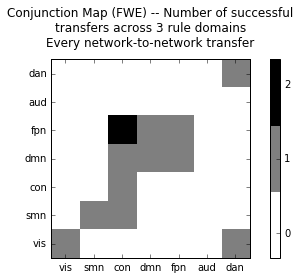

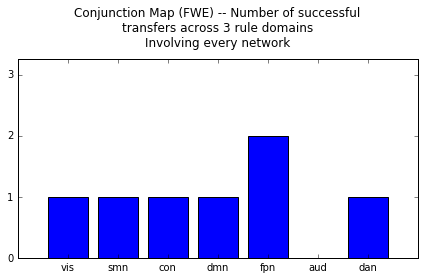

In [60]:
norm = MidpointNormalize(midpoint=0)
plt.figure()
plt.title('Conjunction Map (FWE) -- Number of successful\ntransfers across 3 rule domains\nEvery network-to-network transfer',
          y=1.04)
cmap = plt.get_cmap('binary')
plt.imshow(numDomains_netInvolvedMat,origin='lower',interpolation='nearest',cmap=cmap)
colorbar_index(ncolors=3,cmap=cmap)
# mappable = plt.cm.ScalarMappable(cmap=cm)
# cbar = plt.colorbar(mappable)
# cbar.set_ticks([0,1,2,3])
plt.xticks(range(len(netkeys)),netkeys.values())
plt.yticks(range(len(netkeys)),netkeys.values())
plt.tight_layout()
# plt.savefig('Fig6_FWER_ConjunctionMatrix_ITE_7NETS.pdf')

plt.figure()
plt.title('Conjunction Map (FWE) -- Number of successful\ntransfers across 3 rule domains\nInvolving every network',
          y=1.04)
plt.bar(range(num_networks),numDomains_netInvolvedBar,align='center')
plt.xticks(range(num_networks),netkeys.values())
plt.yticks(range(4),[0,1,2,3])
plt.ylim([0,3.25])
plt.tight_layout()
# plt.savefig('Fig6_FWER_ConjunctionBarPlot_ITE_7NETS.pdf')



## 3.3 Now generate figures for all 14 networks

{0: 'vis', 1: 'smn', 2: 'con', 3: 'fpn_prem', 4: 'prem', 5: 'dmn', 6: 'fpn', 7: 'aud', 8: 'aud2', 9: 'pcc', 10: 'dan', 11: 'none', 12: 'hipp', 13: 'pmulti'}


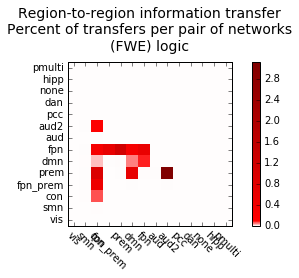

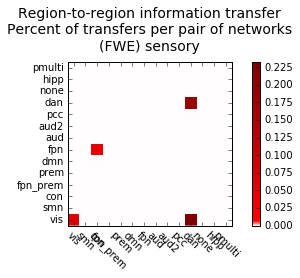

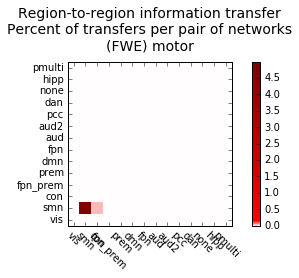

In [61]:
# # Define full set of 14 networks (used in supplementary materials)
networkmappings_full = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud':8, 'aud2':9, 'dan':11,'fpn_prem':4,
                   'prem':5, 'pcc':10, 'none':12, 'hipp':13, 'pmulti':14}
networkdef_full = lg.loadGlasserNetworks()
networks = networkmappings_full.keys()
netkeys = {0:'fpn', 1:'dan', 2:'con', 3:'dmn', 4:'vis', 5:'aud', 6:'smn'}
# Remake order to fit that of the glasser community ordering (region-to-region matrix ordering)
netkeys = {0:'vis',1:'smn',2:'con',3:'fpn_prem', 4:'prem', 5:'dmn', 6:'fpn', 7:'aud', 8:'aud2',
          9:'pcc', 10:'dan', 11:'none', 12:'hipp', 13:'pmulti'}
print netkeys
num_networks=len(netkeys)

netrsa_percent = {}
df_netrsa = {}

rulecount = 0
for ruledim in ruledims:
    netrsa_percent[ruledim] = np.zeros((num_networks,num_networks))
    for net1 in netkeys:
        for net2 in netkeys:
            net1_ind = np.where(networkdef_full==networkmappings_full[netkeys[net1]])[0]
            net1_ind.shape = (len(net1_ind),1)
            net2_ind = np.where(networkdef_full==networkmappings_full[netkeys[net2]])[0]
            net2_ind.shape = (len(net2_ind),1)
            
            thresh = fwe_Ps[:,:,rulecount] < pthresh
            
            netrsa_percent[ruledim][net1,net2] = np.mean(thresh[net1_ind,net2_ind.T])


    plt.figure()
    norm = MidpointNormalize2(midpoint=0)
    mintmp = np.max(netrsa_percent[ruledim]*100.0)*-1.0
    maxtmp = np.max(netrsa_percent[ruledim]*100.0)
    plt.imshow(netrsa_percent[ruledim]*100.0,
               norm=norm, origin='lower', interpolation='none', cmap='seismic')
    plt.xticks(range(len(netkeys)),netkeys.values(), rotation=-45)
    plt.yticks(range(len(netkeys)),netkeys.values())
    plt.title('Region-to-region information transfer\nPercent of transfers per pair of networks\n(FWE) ' + ruledim,
              fontsize=14, y=1.04)
    cbar = plt.colorbar()
    plt.tight_layout()
#     plt.savefig('SFig_ITE_NetworkPercent_AllNets_' + ruledim + '_FWER.pdf')

    rulecount += 1

## 3.3.1 Compute the number of rule domains each network is involved in

In [62]:
numDomains_netInvolvedMat = np.zeros((netrsa_percent['logic'].shape))
numDomains_netInvolvedBar = np.zeros((num_networks,))
for ruledim in ruledims:
    tmp = netrsa_percent[ruledim] > 0
    numDomains_netInvolvedMat = numDomains_netInvolvedMat + tmp
    
    tmp2 = np.sum(netrsa_percent[ruledim] > 0,axis=1) > 0
    numDomains_netInvolvedBar = numDomains_netInvolvedBar + tmp2

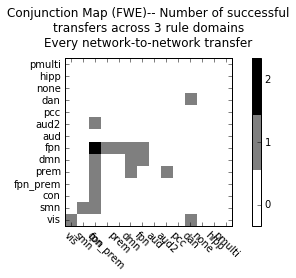

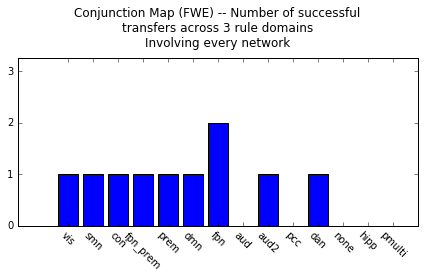

In [63]:
norm = MidpointNormalize(midpoint=0)
plt.figure()
plt.title('Conjunction Map (FWE)-- Number of successful\ntransfers across 3 rule domains\nEvery network-to-network transfer', 
          y=1.04)
cmap = plt.get_cmap('binary')
plt.imshow(numDomains_netInvolvedMat,origin='lower',interpolation='nearest',cmap=cmap)
colorbar_index(ncolors=3,cmap=cmap)
plt.xticks(range(len(netkeys)),netkeys.values(), rotation=-45)
plt.yticks(range(len(netkeys)),netkeys.values())
plt.tight_layout()
# plt.savefig('SFig_ConjunctionMatrix_IT_ALLNETS_FWER.pdf')

plt.figure()
plt.title('Conjunction Map (FWE) -- Number of successful\ntransfers across 3 rule domains\nInvolving every network',
          y=1.04)
plt.bar(range(num_networks),numDomains_netInvolvedBar,align='center')
plt.xticks(range(num_networks),netkeys.values(), rotation=-45)
plt.yticks(range(4),[0,1,2,3])
plt.ylim([0,3.25])
plt.tight_layout()
# plt.savefig('SFig_ConjunctionBarPlot_ITE_ALLNETS_FWER.pdf')

